In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df = (
    pl.read_csv(
        "./data/mkechinov/events.csv",  # https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store
    )
    .lazy()
    .with_columns(pl.col("event_time").str.replace(" UTC", ""))
    .with_columns(pl.col("event_time").str.to_datetime(format="%Y-%m-%d %H:%M:%S"))
    .with_columns(
        lagged=pl.col("event_time")
        .shift(1)
        .over(pl.col("user_id"), order_by=pl.col("event_time"))
    )
    .with_columns(time_diff=pl.col("event_time") - pl.col("lagged"))
    .with_columns(time_diff_mins=pl.col("time_diff").dt.total_minutes())
)

In [60]:
users_greater_10_sessions = df.group_by("user_id").agg(
    pl.col("user_session").n_unique().alias("n_sessions"),
    pl.col("event_type").is_in(["purchase"]).sum().alias("n_purchases"),
).filter(pl.col("n_sessions") > 10)


In [61]:
sessions = df.group_by("user_session").agg(
    pl.col("event_time").min().alias("first_event"),
    pl.col("event_time").max().alias("last_event"),
    pl.col('user_id').first().alias('user_id')
).with_columns(
    session_duration=pl.col("last_event") - pl.col("first_event")
)
sessions.collect()

user_session,first_event,last_event,user_id,session_duration
str,datetime[μs],datetime[μs],i64,duration[μs]
"""oinwgD2Oq0""",2020-12-06 18:44:15,2020-12-06 18:44:15,1515915625550773902,0µs
"""7b8mCT8gfJ""",2021-01-26 09:40:08,2021-01-26 09:40:08,1515915625596956207,0µs
"""jqqWrv4OVN""",2020-10-12 19:30:14,2020-10-12 19:36:50,1515915625517305727,6m 36s
"""nlMUYO6gdc""",2021-01-24 07:24:47,2021-01-24 07:24:47,1515915625596470056,0µs
"""vvjPLTsGx1""",2021-02-24 17:18:35,2021-02-24 17:18:35,1515915625609211548,0µs
…,…,…,…,…
"""Et5dZ84CO8""",2021-01-09 05:27:45,2021-01-09 05:27:45,1515915625590905486,0µs
"""KFWEpJHFzH""",2020-11-14 12:30:00,2020-11-14 12:30:00,1515915625539290050,0µs
"""Aq4FQAfbut""",2020-10-10 08:09:35,2020-10-10 08:09:35,1515915625523640894,0µs


In [88]:
dist_time_between_sessions = sessions.join(users_greater_10_sessions, on="user_id", how="inner").group_by(
    "user_id"
).agg(
    pl.col("first_event")
    .sort()
    .diff()
    .slice(1)
    .dt.total_hours()
    .alias("avg_time_between_sessions")
).collect()

<Axes: ylabel='Count'>

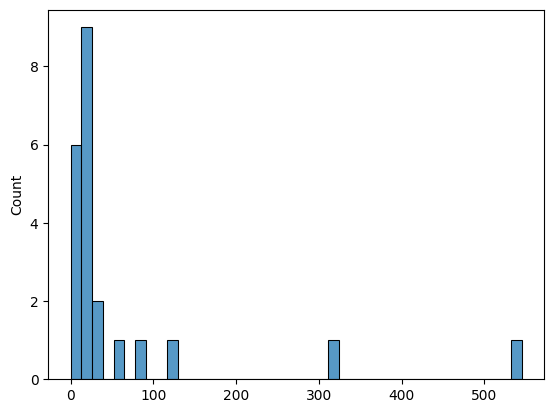

In [92]:
sns.histplot(dist_time_between_sessions.to_pandas()["avg_time_between_sessions"][3])

In [115]:
users_session_dist = (
    df.group_by("user_id")
    .agg(
        pl.col("user_session").n_unique().alias("n_sessions"),
        pl.col("event_type").is_in(["purchase"]).sum().alias("n_purchases"),
    )
).collect().to_pandas()

<Axes: xlabel='n_sessions', ylabel='Count'>

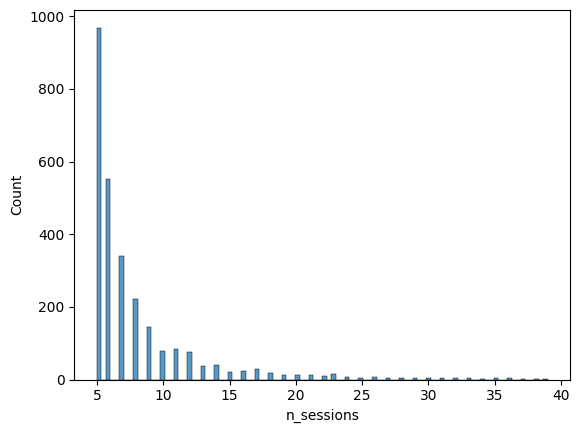

In [121]:
sns.histplot(users_session_dist["n_sessions"].loc[users_session_dist["n_sessions"].between(5, 40)], bins=100)

In [124]:
users_session_dist = (
    df.group_by("user_id")
    .agg(
        pl.col("user_session").n_unique().alias("n_sessions"),
        pl.col("event_type").is_in(["purchase"]).sum().alias("n_purchases"),
    )
    .group_by("n_sessions")
    .agg(
        pl.col("n_sessions").count().alias("n_users"),
        pl.col("n_purchases").sum().alias("n_purchases"),
    )
    .sort("n_sessions")
    .collect()
    .to_pandas()
)

In [128]:
users_session_dist["n_purchases"] / users_session_dist["n_users"]

0     0.048517
1     0.270329
2     0.580216
3     0.813064
4     1.011352
        ...   
68    0.000000
69    0.000000
70    1.000000
71    1.000000
72    4.000000
Length: 73, dtype: float64